In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pmdarima as pm
import math
from sklearn.preprocessing import MinMaxScaler
import warnings
import torch
import torch.nn as nn
from datasets.ingest import yf_to_sql
from features.data_cleaning import PreProcess
from models.keras_lstm import LSTMmodel
from features.evaluation import ErrorMetrics
from features.plot import ts_plot
from datasets.explore import EDA

In [2]:
yts = yf_to_sql()
stock_df = yts.ioc_data()   # this will prompt you to run the SQL
stock_df.head()

,close,log_close
date,,
2015-12-04,38.48,3.65
2015-12-05,38.48,3.65
2015-12-06,38.48,3.65
2015-12-07,38.51,3.65
2015-12-08,37.96,3.64


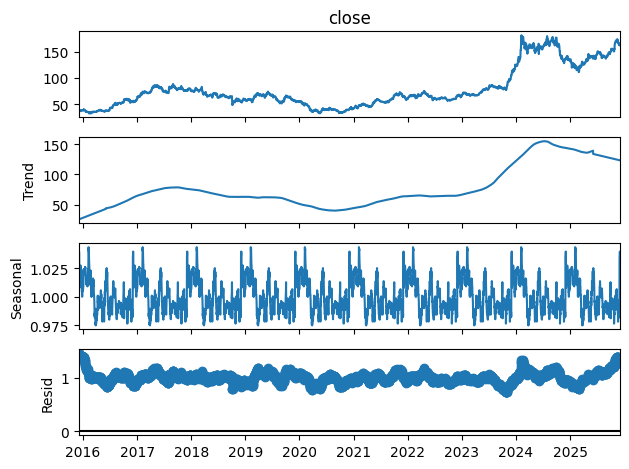

In [3]:
#Decomposition of TimeSeries models
eda = EDA(stock_df)
eda.decomposition()
    

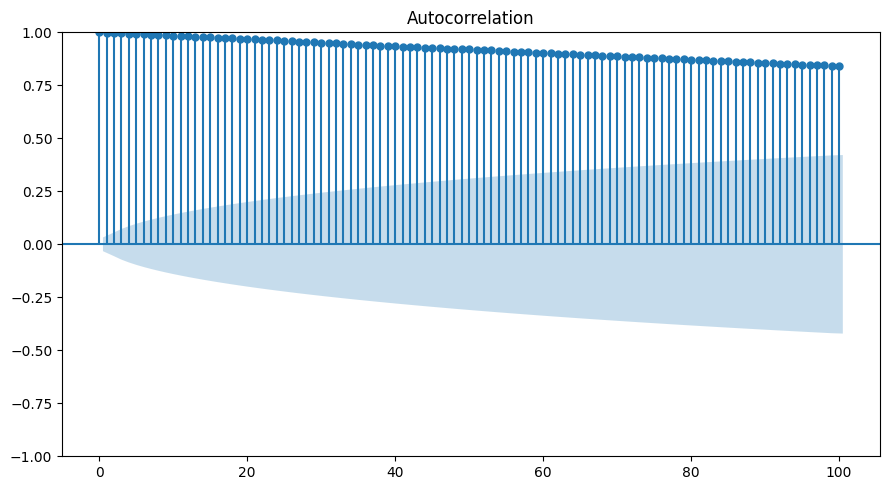

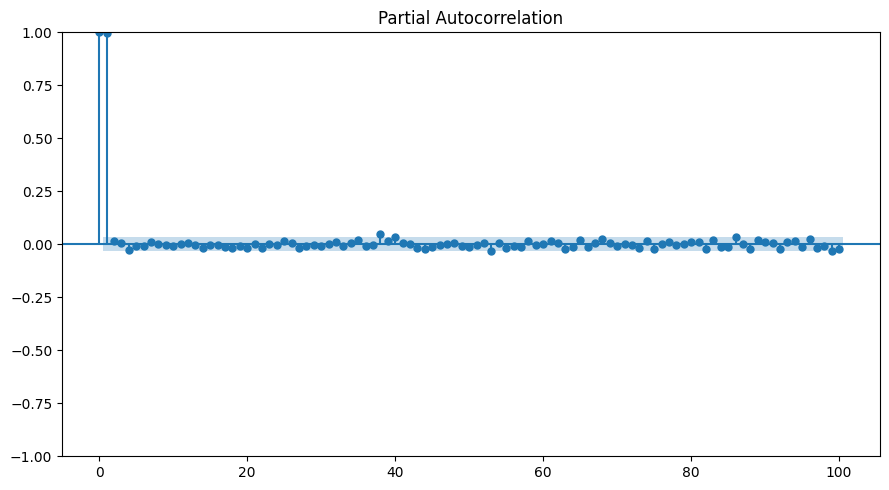

In [4]:
eda.acf_pacf(100)

In [5]:
#Dicky fuller test
#H0: Non Stationary
#H1: Stationary

eda.adfuller_test()

Test statistic                   -0.323684
p-value                           0.922082
Lags Used                        19.000000
Number of Observations Used    3634.000000
dtype: float64

In [6]:
# Degree of differencing
eda.deg_of_def()

The degree of differencing is 1


c:\Users\amjit\miniconda3\envs\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\amjit\miniconda3\envs\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\amjit\miniconda3\envs\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\amjit\miniconda3\envs\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\amjit\miniconda3\envs\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

In [13]:
def tt_split(df, train_size = 0.8):
    size= int(len(df['log_close'])*train_size)

    train_df = (df['log_close']).iloc[:size].copy()
    test_df = (df['log_close']).iloc[size:].copy()

    plt.figure(figsize=(10,6))
    plt.grid(True, linestyle="--", alpha=0.5)   # lighter grid
    plt.xlabel('Days')
    plt.ylabel('Closing Prices (log scale)')
    plt.title("Train vs Test Data (Log Transformed)")
    plt.plot(train_df, color='green', label='Train data')
    plt.plot(test_df, color='blue', label='Test data')

    plt.legend()
    plt.show()

    return train_df, test_df

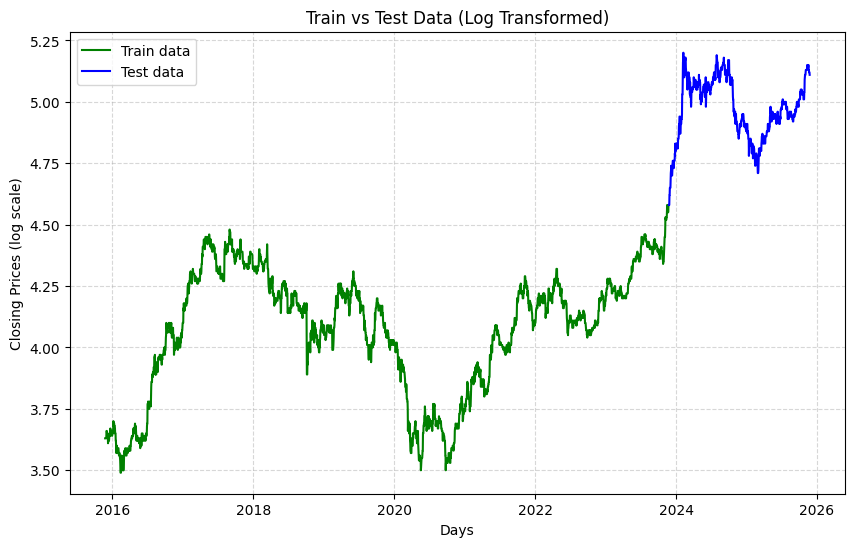

In [14]:
train_y, test_y = tt_split(stock_df)

In [15]:
def fit_arima(df):
    warnings.simplefilter(action = 'ignore', category = Warning)
    print("Arima model for iocl")
    model = pm.auto_arima(df, test = 'adf', start_p=0, start_q=0, max_p=3, max_q=3, 
                          m=5, d=None, seasonal=True, start_P=0, D=None,start_Q=0, max_P=2, max_Q=2, trace = True,
                          error_action= 'ignore', suppress_warnings=True, stepwise=True)
    print(model.summary())
    model.plot_diagnostics(figsize= (15, 8))
    plt.show()

Arima model for iocl
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-15940.972, Time=0.33 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-15940.123, Time=1.81 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-15940.155, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-15941.736, Time=0.17 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=-15939.169, Time=1.10 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=-15939.154, Time=0.69 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=-15936.985, Time=1.56 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-15941.927, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=-15940.109, Time=1.02 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=-15937.800, Time=0.76 sec
 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=-15940.120, Time=3.17 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-15940.291, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-15941.974, Time=0.37 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=-15940.170

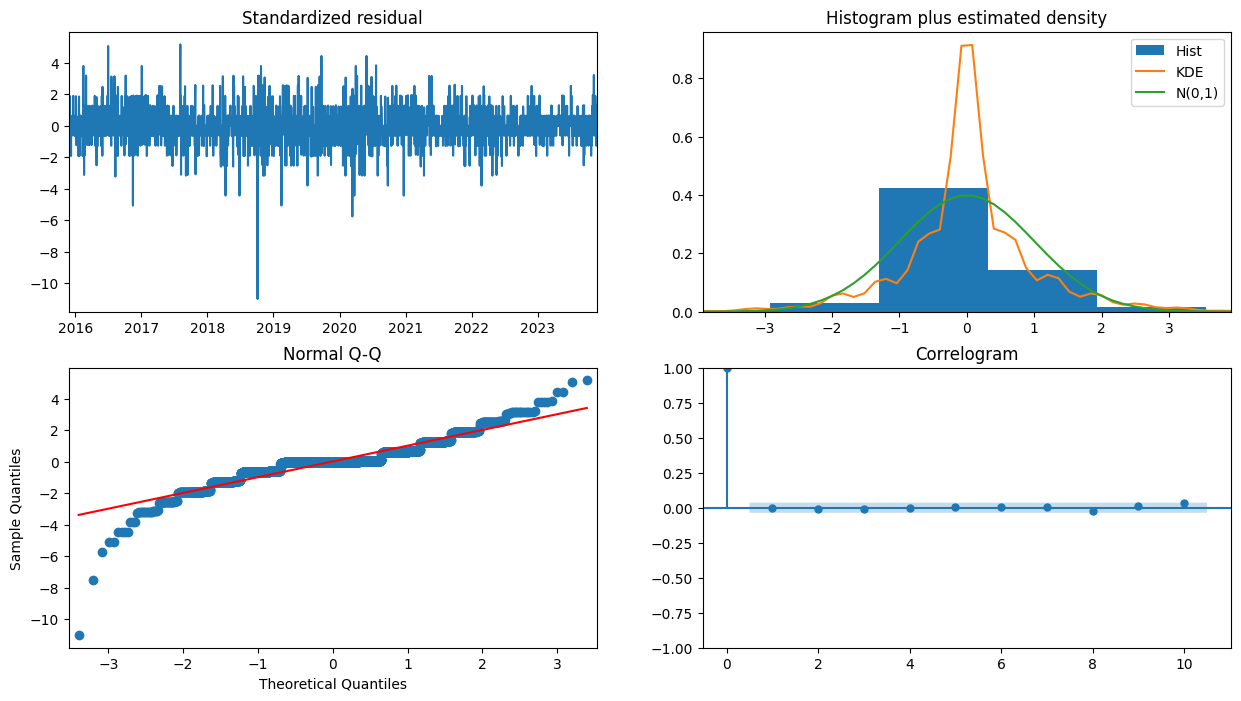

In [16]:
fit_arima(train_y)

In [18]:
# forcibly disable system warnings
warnings.simplefilter(action = 'ignore', category = Warning)
 
# importing the model class 
# let's create an object of this model
model = SARIMAX(train_y, 
                order = (0, 1, 1), 
                seasonal_order = (0, 0, 0, 252),
                enforce_stationarity = False, 
                enforce_invertibility = False)
 
# apply the method fit
fitted = model.fit(maxiter = 500, method = 'nm')

Optimization terminated successfully.
         Current function value: -2.725580
         Iterations: 16
         Function evaluations: 33


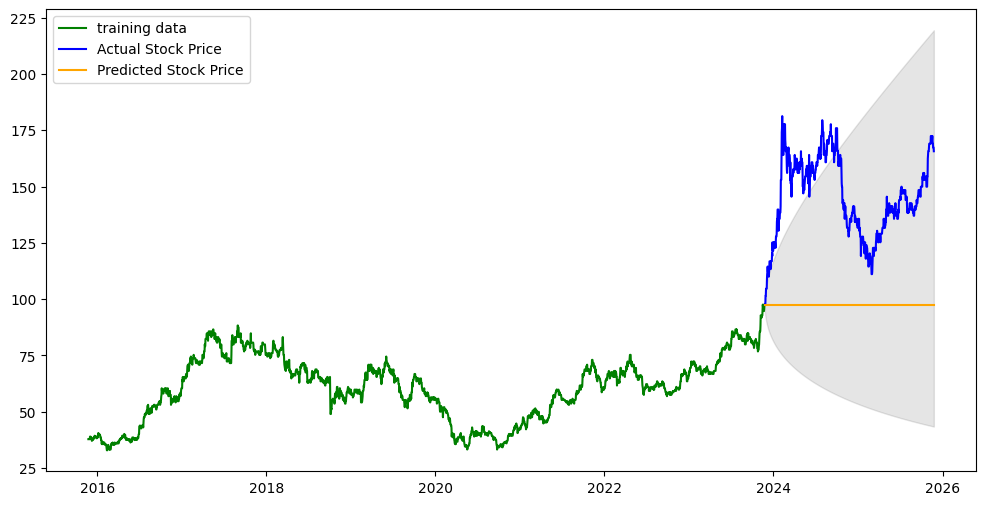

In [19]:
steps= len(test_y)
forecast_obj = fitted.get_forecast(steps=steps)
fc_log = forecast_obj.predicted_mean
conf_log = forecast_obj.conf_int(alpha=0.05)
fc = np.exp(fc_log)
conf = np.exp(conf_log)
fc.index = test_y.index
conf.index = test_y.index

# Plot
plt.figure(figsize=(12,6), dpi=100)
plt.plot(np.exp(train_y),color = 'green', label='training data')
plt.plot(np.exp(test_y), color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], 
                 color='k', alpha=0.1)
plt.legend()
plt.show()

In [20]:
# report performance

mse = mean_squared_error(np.exp(test_y), fc)
mae = mean_absolute_error(np.exp(test_y), fc)
rmse = math.sqrt(mean_squared_error(np.exp(test_y), fc))
mape = np.mean(np.abs(fc - np.exp(test_y))/np.abs(test_y))

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:',rmse)
print('MAPE:', mape)

MSE: 2606.301627879912
MAE: 47.97787965304884
RMSE: 51.05195028478258
MAPE: 9.566807916881322


In [21]:
fitted_vals = np.exp(fitted.fittedvalues)
fitted_df = pd.DataFrame({
    "date": train_y.index,
    "forecast": fitted_vals,
})
forecast_df = pd.DataFrame({
    "date": test_y.index,
    "forecast": fc.values,
})

pred_df = pd.concat([fitted_df,forecast_df])
pred_df.reset_index(drop= True, inplace=True)

In [ ]:
sql_push(pred_df, table_name= "iocl_arima")

In [22]:
lstm_df = pd.read_sql("SELECT date, close FROM iocl", engine)
stock_lstm_df = index_date(lstm_df)
#dataset = stock_res_df.values.reshape(-1,1)
stock_lstm_df.head()

,close
date,
2015-04-01,32.74
2015-04-06,33.04
2015-04-07,32.88
2015-04-08,33.32
2015-04-09,33.13


In [23]:
scaler = MinMaxScaler(feature_range=(-1,1))
stock_lstm_df['close'] = scaler.fit_transform(stock_lstm_df['close'].values.reshape(-1,1))

stock_lstm_df.head()

,close
date,
2015-04-01,-0.953676
2015-04-06,-0.949716
2015-04-07,-0.951828
2015-04-08,-0.946021
2015-04-09,-0.948528


In [24]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
          
    data = np.array(data)
    train_set_size = int(np.round(0.91*data.shape[0]))
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [25]:
look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_lstm_df, look_back)

In [26]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2339, 59, 1)
y_train.shape =  (2339, 1)
x_test.shape =  (231, 59, 1)
y_test.shape =  (231, 1)


In [27]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train.size(), x_train.size()

(torch.Size([2339, 1]), torch.Size([2339, 59, 1]))

In [ ]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [29]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =60-1 

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.11013161391019821
Epoch  20 MSE:  0.03269987180829048
Epoch  30 MSE:  0.012961098924279213
Epoch  40 MSE:  0.006307708099484444
Epoch  50 MSE:  0.003387936856597662
Epoch  60 MSE:  0.0019084084779024124
Epoch  70 MSE:  0.001450808485969901
Epoch  80 MSE:  0.0012189170811325312
Epoch  90 MSE:  0.0011065363651141524


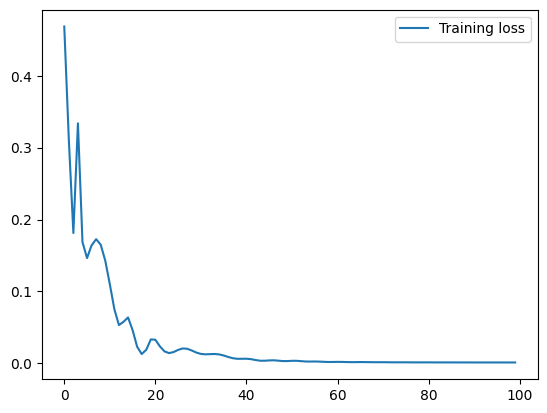

In [30]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [31]:
# make predictions
y_test_pred = model(x_test)


# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.48 RMSE
Test Score: 3.39 RMSE


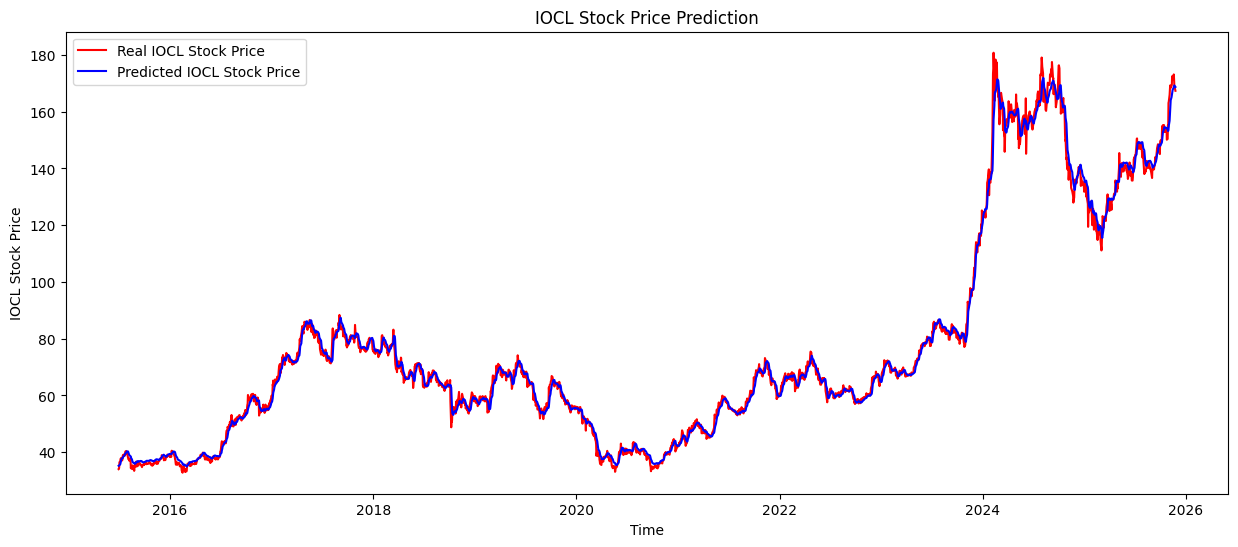

In [32]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(stock_lstm_df[60:].index, np.concatenate([y_train,y_test]).ravel(), color = 'red', label = 'Real IOCL Stock Price')
axes.plot(stock_lstm_df[60:].index, np.concatenate([y_train_pred, y_test_pred]).ravel(), color = 'blue', label = 'Predicted IOCL Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IOCL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IOCL Stock Price')
plt.legend()
plt.show()